In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Video segmentation with SAM 2

This notebook shows how to use SAM 2 for interactive segmentation in videos. It will cover the following:

- adding clicks (or box) on a frame to get and refine _masklets_ (spatio-temporal masks)
- propagating clicks (or box) to get _masklets_ throughout the video
- segmenting and tracking multiple objects at the same time

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video. 

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything-2/blob/main/notebooks/video_predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `segment-anything-2` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything-2#installation) in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

## Set-up

In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from jupyter_bbox_widget import BBoxWidget

In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


### Loading the SAM 2 video predictor

In [4]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [5]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))


# Function to convert PNG frames to JPG and save them in the output directory
def convert_png_to_jpg(frame_names, video_dir, output_dir):
    for frame_name in frame_names:
        if frame_name.lower().endswith(".png"):
            # Get the full path of the PNG file
            png_path = os.path.join(video_dir, frame_name)
            # Create the corresponding JPG filename in the output directory
            jpg_name = os.path.splitext(frame_name)[0] + ".jpg"
            jpg_path = os.path.join(output_dir, jpg_name)
            
            # Open the PNG image, convert to RGB, and save as JPG in output_dir
            with Image.open(png_path) as img:
                rgb_img = img.convert('RGB')
                rgb_img.save(jpg_path, "JPEG")


def bbox_to_box(bbox):
    # Directly extract x, y, width, and height from the dictionary
    x = bbox['x']
    y = bbox['y']
    width = bbox['width']
    height = bbox['height']

    # Convert to [x0, y0, x1, y1] format
    x0 = x
    y0 = y
    x1 = x + width
    y1 = y + height

    # Save as a NumPy array
    box = np.array([x0, y0, x1, y1], dtype=np.float32)
    return box


def bboxes_to_points(bboxes):

    points = []

    for bbox in bboxes:
        x = bbox['x']
        y = bbox['y']

        point = np.array([x, y], dtype=np.float32)
        points.append(point)

    return np.array(points)

#### Select an example video

In [6]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "/home/martyn/Thesis/pose-tracking/data/frames/scene_04/rgb/"
video_jpg_dir = "/home/martyn/Thesis/pose-tracking/data/frames/scene_04/rgb_jpg/"

# Create the output directory if it doesn't exist
os.makedirs(video_jpg_dir, exist_ok=True)

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG", ".png", ".PNG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# Convert PNG frames to JPG and save them in the output_dir
convert_png_to_jpg(frame_names, video_dir, video_jpg_dir)

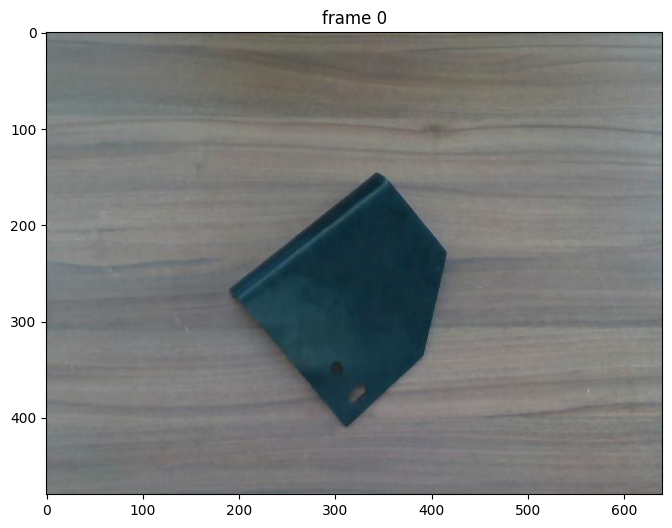

In [7]:
# Re-scan frame names from the output_dir (now only JPGs should be present)
frame_names = [
    p for p in os.listdir(video_jpg_dir)
    if os.path.splitext(p)[-1].lower() in [".jpg", ".jpeg"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_jpg_dir, frame_names[frame_idx])))

#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [8]:
inference_state = predictor.init_state(video_path=video_jpg_dir)

frame loading (JPEG): 100%|██████████| 452/452 [00:08<00:00, 52.83it/s]


### Example 2: Segment an object using box prompt

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

In [9]:
predictor.reset_state(inference_state)

In addition to using clicks as inputs, SAM 2 also supports segmenting and tracking objects in a video via **bounding boxes**.

In the example below, we segment the child on the right using a **box prompt** of (x_min, y_min, x_max, y_max) = (300, 0, 500, 400) on frame 0 as input into the `add_new_points_or_box` API.

In [9]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

widget = BBoxWidget(
    image = os.path.join(video_jpg_dir, frame_names[ann_frame_idx]),
    classes=['part', 'hole'],
)
widget

BBoxWidget(classes=['part', 'hole'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',…

In [ ]:
#bbox = widget.bboxes
#points = bboxes_to_points(bbox)
#points

/home/martyn/Thesis/sam2/sam2/sam2_video_predictor.py:961: UserWarning: cannot import name '_C' from 'sam2' (/home/martyn/Thesis/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


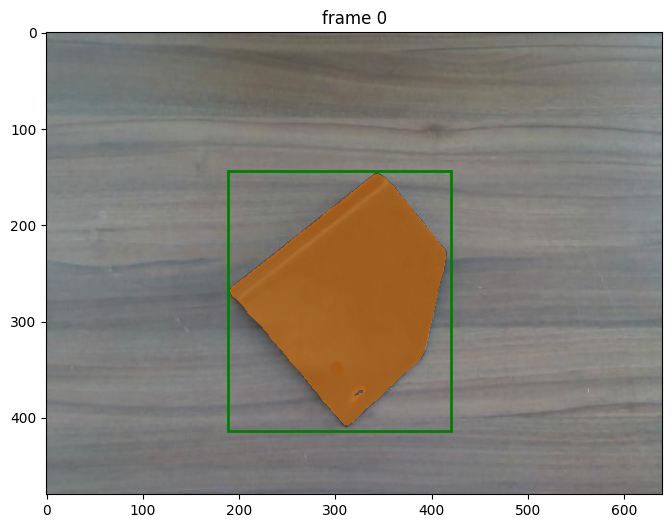

In [10]:
bbox = widget.bboxes[0]
box = bbox_to_box(bbox)

_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    box=box,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_jpg_dir, frame_names[ann_frame_idx])))
show_box(box, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

Here, SAM 2 gets a pretty good segmentation mask of the entire child, even though the input bounding box is not perfectly tight around the object.

Similar to the previous example, if the returned mask from is not perfect when using a box prompt, we can also further **refine** the output using positive or negative clicks. To illustrate this, here we make a **positive click** at (x, y) = (460, 60) with label `1` to expand the segment around the child's hair.

Note: to refine the segmentation mask from a box prompt, we need to send **both the original box input and all subsequent refinement clicks and their labels** when calling `add_new_points_or_box`.

Then, to get the masklet throughout the entire video, we propagate the prompts using the `propagate_in_video` API.

propagate in video: 100%|██████████| 452/452 [00:16<00:00, 27.89it/s]


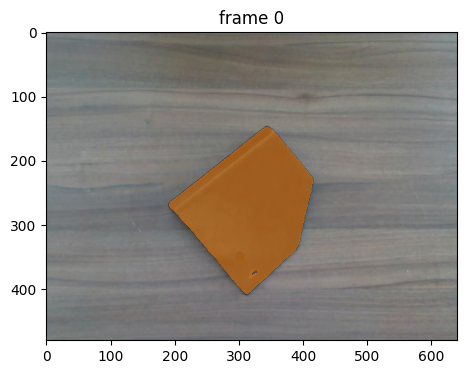

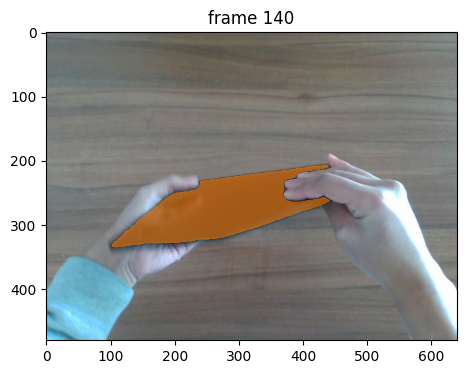

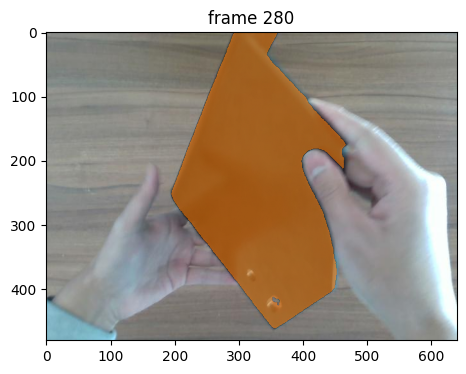

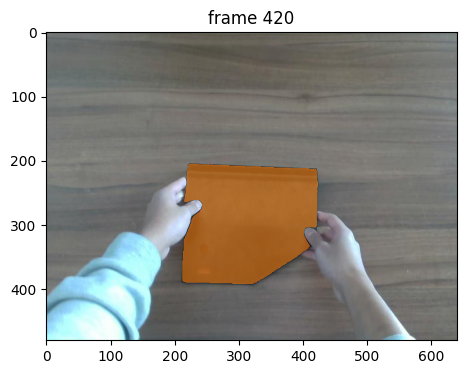

In [11]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 140
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_jpg_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

Note that in addition to clicks or boxes, SAM 2 also supports directly using a **mask prompt** as input via the `add_new_mask` method in the `SAM2VideoPredictor` class. This can be helpful in e.g. semi-supervised VOS evaluations (see [tools/vos_inference.py](https://github.com/facebookresearch/segment-anything-2/blob/main/tools/vos_inference.py) for an example).

In [12]:
# Create output directory for saving binary masks
mask_output_dir = "/home/martyn/Thesis/pose-tracking/data/frames/scene_04/masks/"
os.makedirs(mask_output_dir, exist_ok=True)

# Save the binary masks with the same name as the corresponding JPG frame
for out_frame_idx, masks in video_segments.items():
    # Use the corresponding JPG frame name
    frame_name = os.path.splitext(frame_names[out_frame_idx])[0]  # Get the frame name without extension
    
    for out_obj_id, out_mask in masks.items():
        # Ensure the mask is binary (0 for background, 1 for foreground)
        out_mask = (out_mask > 0).astype(np.uint8)
        
        # Remove any singleton dimensions and ensure the mask is 2D
        out_mask = np.squeeze(out_mask)
        
        # Scale mask values to [0, 255]
        binary_mask = Image.fromarray(out_mask * 255, mode='L')
        
        # Save the mask with the same name as the corresponding JPG frame
        mask_filename = f"{frame_name}.png"
        binary_mask.save(os.path.join(mask_output_dir, mask_filename))